In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import lightgbm as ltb


In [3]:
X_test = pd.read_csv('/Users/butler/Documents/hp/Capstone_Two/data/processed/X_test_asthma')
X_train = pd.read_csv('/Users/butler/Documents/hp/Capstone_Two/data/processed/X_train_asthma')
y_test = pd.read_csv('/Users/butler/Documents/hp/Capstone_Two/data/processed/y_test_asthma')
y_train = pd.read_csv('/Users/butler/Documents/hp/Capstone_Two/data/processed/y_train_asthma')

In [4]:
X_test.drop('CensusTract', axis=1, inplace=True)
X_train.drop('CensusTract', axis=1, inplace=True)
y_test.drop('CensusTract', axis=1, inplace=True)
y_train.drop('CensusTract', axis=1, inplace=True)


In [5]:
y_test = np.ravel(y_test)
y_train = np.ravel(y_train)
y_train.shape


(54242,)

In [6]:
X_test.shape

(18081, 11)

In [7]:
X_test.head()

,PM25,OZONE,DieselPM,AirToxicsRisk,RESP,PTRAF,PRE1960PCT,PNPL,PRMP,PTSDF,PWDIS
0,7.367790,42.683730,0.270750,25.997500,0.370442,276.557182,0.113820,0.606326,0.023621,1.023876,0.000000
1,7.441957,31.635196,0.404162,28.767412,0.421161,265.197995,0.081084,0.089128,0.666353,0.650670,0.000000
2,6.126674,38.134998,0.273680,21.685292,0.268528,158.051760,0.213232,0.054709,0.065434,0.091733,0.000137
3,8.897398,37.102196,0.864184,56.793938,0.555000,312.222180,0.243171,0.055795,0.249290,2.842095,0.000000
4,4.942090,51.246733,0.426470,16.674490,0.254559,369.266221,0.316813,0.171198,0.433149,1.947524,0.053605


In [8]:
X_train.head()

,PM25,OZONE,DieselPM,AirToxicsRisk,RESP,PTRAF,PRE1960PCT,PNPL,PRMP,PTSDF,PWDIS
0,9.218632,42.432010,0.437587,42.797994,0.555932,116.146188,0.059431,0.111265,1.430894,3.723781,9.340378e-05
1,5.480731,32.707033,0.090776,20.703235,0.253421,147.360359,0.203873,0.023173,0.205648,0.257422,8.166893e-07
2,8.271858,33.984420,0.457610,40.204311,0.528250,631.912988,0.357798,0.314533,0.796118,4.365424,2.934346e-02
3,8.525349,35.396559,0.634498,35.927295,0.656640,339.121897,0.694382,1.537420,5.416626,0.977925,1.564409e-02
4,9.580904,37.130092,0.405429,35.615286,0.537506,113.205731,0.004695,0.050769,0.848018,2.453090,1.083414e-03


In [9]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(54242, 11) (54242,) (18081, 11) (18081,)


In the pre-processeing notebook, I have already done multiple OLS on the data and found no reasonable correlation. In this notebook, the first type of model I will use will be random forest.

In [10]:
# Instantiate RandomForestRegressor and randomly search for best hyperparameters n_estimators and max_depth
rf = RandomForestRegressor() 
params = {'n_estimators': sp_randInt(1,500), 'max_depth':sp_randInt(1,30)}

rs = RandomizedSearchCV(rf, params)

In [11]:
rs.fit(X_train, y_train)   

RandomizedSearchCV(estimator=RandomForestRegressor(),
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x15521e220>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x155211370>})

In [12]:
rs.best_estimator_

RandomForestRegressor(max_depth=29, n_estimators=401)

In [13]:
rf = RandomForestRegressor(max_depth=29, n_estimators=401)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=29, n_estimators=401)

In [14]:
y_pred = rf.predict(X_test)

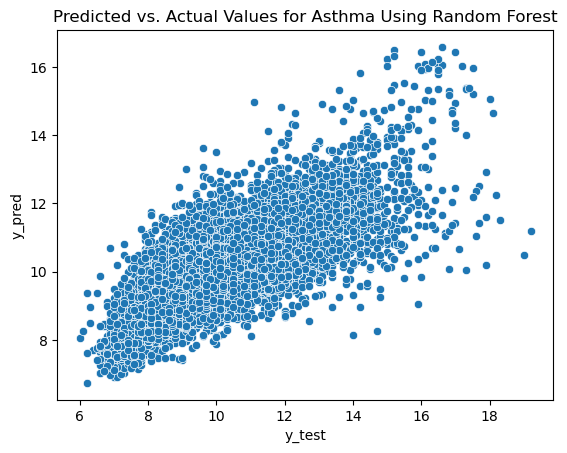

In [15]:
ax = sns.scatterplot(x=y_test, y=y_pred)
_ = ax.set_title('Predicted vs. Actual Values for Asthma Using Random Forest')
_ = ax.set_xlabel('y_test')
_ = ax.set_ylabel('y_pred')

In [16]:
print('R2 score:', r2_score(y_test, y_pred)  )
print('MAE:', mean_absolute_error(y_test, y_pred))
print('MSE:', mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))

R2 score: 0.5578623025959468
MAE: 0.7552253168884185
MSE: 1.073481324160675
RMSE: 1.0360894383018655


This is better than the OLS model although the results are still not very good.

In [ ]:
# Instantiating AdaBoostRegressor and fitting it to the training data
ada = AdaBoostRegressor()
ada.fit(X_train, y_train)

AdaBoostRegressor()

In [ ]:
y_pred = ada.predict(X_test)

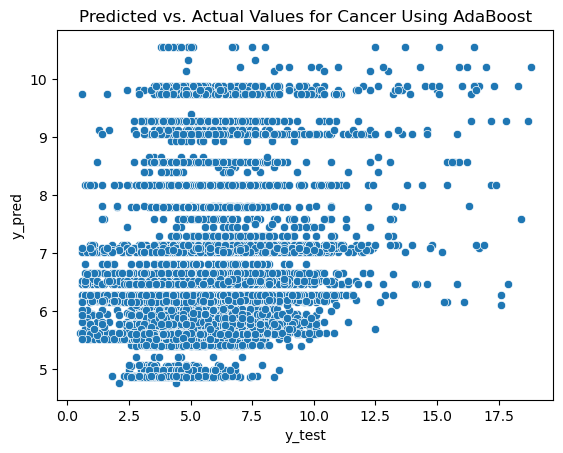

In [ ]:
ax = sns.scatterplot(x=y_test, y=y_pred)
_ = ax.set_title('Predicted vs. Actual Values for Cancer Using AdaBoost')
_ = ax.set_xlabel('y_test')
_ = ax.set_ylabel('y_pred')

In [ ]:
print('R2 score:', r2_score(y_test, y_pred)  )
print('MAE:', mean_absolute_error(y_test, y_pred))
print('MSE:', mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))

R2 score: -0.03404484159174981
MAE: 1.3675407630942722
MSE: 3.419808487689778
RMSE: 1.8492724211672487


Since Adaboost with the default hyperparameters is not giving reasonable results, the next step will be to search for the best hyperparameters.

In [ ]:
# Instantiate AdaBoost Regressor and randomly search for best hyperparameters n_estimators and learning rate
ada = AdaBoostRegressor()
params = {'n_estimators': sp_randInt(1,500), 'learning_rate':sp_randFloat(1e-3,100)}

rs = RandomizedSearchCV(ada, params)

In [ ]:
rs.fit(X_train, y_train)

RandomizedSearchCV(estimator=AdaBoostRegressor(),
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x16b33b460>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x16a9581f0>})

In [ ]:
rs.best_estimator_

AdaBoostRegressor(learning_rate=74.30396622508137, n_estimators=3)

In [ ]:
ada = AdaBoostRegressor(learning_rate=74.30396622508137, n_estimators=3)
ada.fit(X_train, y_train)

AdaBoostRegressor(learning_rate=74.30396622508137, n_estimators=3)

In [ ]:
y_pred = ada.predict(X_test)

In [ ]:
print('R2 score:', r2_score(y_test, y_pred)  )
print('MAE:', mean_absolute_error(y_test, y_pred))
print('MSE:', mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))

R2 score: -9.00915180509855
MAE: 5.461290857806536
MSE: 33.10241579558651
RMSE: 5.753469891777179


This just made the results worse. Next will be Gradient Boost Regressor.

In [ ]:
gb = GradientBoostingRegressor()
gb.fit(X_train, y_train)

GradientBoostingRegressor()

In [ ]:
y_pred = gb.predict(X_test)

In [ ]:
print('R2 score:', r2_score(y_test, y_pred)  )
print('MAE:', mean_absolute_error(y_test, y_pred))
print('MSE:', mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))

R2 score: 0.26896822936933873
MAE: 1.1164367105044624
MSE: 2.417679150282576
RMSE: 1.5548887903263615


This is still not as good as Random Forest. Next model will be XGBoost.

In [ ]:
xgb = XGBRegressor()
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [ ]:
y_pred = xgb.predict(X_test)

In [ ]:
print('R2 score:', r2_score(y_test, y_pred)  )
print('MAE:', mean_absolute_error(y_test, y_pred))
print('MSE:', mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))

R2 score: 0.37715857323054647
MAE: 1.0228488650041294
MSE: 2.0598704350888597
RMSE: 1.4352248726554524


This is still not as good as Random Forest, so I will do hyperparameter tuning on max_depth, min_child_weight, and gamma.

In [ ]:
# Instantiate XGBRegressor and randomly search for best hyperparameters n_estimators and learning rate
xgb = XGBRegressor()
params = {'max_depth': sp_randInt(1,200), 'min_child_weight':sp_randInt(1,200), 'gamma':sp_randInt(1,200)}

rs = RandomizedSearchCV(xgb, params)

In [ ]:
rs.fit(X_train, y_train)

RandomizedSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None,...
                                          n_estimators=100, n_jobs=None,
                                          num_parallel_tree=None,
                                          predictor=None, random_state=None, ...),
                   param_distributions={'gamma': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x16bd77e80>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x16a4f90a0>,
                                        'min_child_weight': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x16bd99220>})

In [ ]:
rs.best_params_

{'gamma': 2, 'max_depth': 166, 'min_child_weight': 36}

In [ ]:
xgb = XGBRegressor(gamma=2, max_depth=166, min_child_weight=36)
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=2, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=166, max_leaves=None,
             min_child_weight=36, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [ ]:
y_pred = xgb.predict(X_test)

In [ ]:
print('R2 score:', r2_score(y_test, y_pred)  )
print('MAE:', mean_absolute_error(y_test, y_pred))
print('MSE:', mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))

R2 score: 0.4086372563854649
MAE: 1.002311917629319
MSE: 1.9557636657259614
RMSE: 1.3984862050538651


This is slightly better than XGBoost without tuning the hyperparameters, but it is still not as good as Random Forest. I will try LightGBM.

In [ ]:
lgbm = ltb.LGBMRegressor()
params = {'reg_alpha': sp_randFloat(1e-3,100), 'reg_lambda': sp_randFloat(1e-3,100)}

rs = RandomizedSearchCV(lgbm, params)

In [ ]:
rs.fit(X_train, y_train)

RandomizedSearchCV(estimator=LGBMRegressor(),
                   param_distributions={'reg_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x1561c30d0>,
                                        'reg_lambda': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x1561e5f40>})

In [ ]:
rs.best_estimator_

LGBMRegressor(reg_alpha=21.79723530737549, reg_lambda=28.68886058041305)

In [ ]:
lgbm = ltb.LGBMRegressor(boosting_type='gbdt', num_leaves=31, max_depth=-1, learning_rate=0.1, n_estimators=100, reg_alpha=21.79723530737549, reg_lambda=28.68886058041305)
lgbm.fit(X_train, y_train) 

LGBMRegressor(reg_alpha=21.79723530737549, reg_lambda=28.68886058041305)

In [ ]:
y_pred = lgbm.predict(X_test)

In [ ]:
print('R2 score:', r2_score(y_test, y_pred)  )
print('MAE:', mean_absolute_error(y_test, y_pred))
print('MSE:', mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))

R2 score: 0.35852413110397674
MAE: 0.5671163535626224
MSE: 0.6279176297057645
RMSE: 0.7924125375748193


This is still not as good as Random Forest. The next model I will try is a support vector machine regressor, but first I have to import the normalized data.

The next model I will try is a support vector machine regressor.

In [3]:
# Need normalized data
X_test_log = pd.read_csv('/Users/butler/Documents/hp/Capstone_Two/data/processed/X_test_log_asthma')
X_train_log = pd.read_csv('/Users/butler/Documents/hp/Capstone_Two/data/processed/X_train_log_asthma')
y_test_log = pd.read_csv('/Users/butler/Documents/hp/Capstone_Two/data/processed/y_test_log_asthma')
y_train_log = pd.read_csv('/Users/butler/Documents/hp/Capstone_Two/data/processed/y_train_log_asthma')

In [6]:
X_test_log.drop('CensusTract', axis=1, inplace=True)
X_train_log.drop('CensusTract', axis=1, inplace=True)
y_test_log.drop('CensusTract', axis=1, inplace=True)
y_train_log.drop('CensusTract', axis=1, inplace=True)


In [17]:
y_test_log = np.ravel(y_test_log)
y_train_log = np.ravel(y_train_log)
print(y_train_log.shape, X_test_log.shape)


(54242,) (18081, 10)


In [10]:
X_test_log.head()

,PM25,OZONE,DieselPM,AirToxicsRisk,RESP,PTRAF,PRE1960PCT,PNPL,PRMP,PTSDF
0,7.959870,43.977497,-0.889370,-0.586657,-0.732266,-1.794902,0.560243,-0.335463,-0.462965,-1.056582
1,7.307600,40.690133,-1.313037,-1.697330,-1.682755,-1.372705,1.051735,-1.211491,1.425167,-1.132903
2,9.267414,44.258576,0.275996,-0.164004,-0.541962,0.167441,-1.122111,0.329754,0.684080,0.086938
3,6.875682,42.507329,-0.388826,-0.741405,-0.947215,-0.146837,0.838659,-0.117047,1.264306,1.267095
4,10.494505,31.453638,0.517422,0.005686,0.614166,-0.053250,1.510884,-0.370919,1.338506,1.371901


In [ ]:
X_train.head()

,PM25,OZONE,DieselPM,AirToxicsRisk,RESP,PTRAF,PRE1960PCT,PNPL,PRMP,PTSDF,PWDIS
0,9.218632,42.432010,0.437587,42.797994,0.555932,116.146188,0.059431,0.111265,1.430894,3.723781,9.340378e-05
1,5.480731,32.707033,0.090776,20.703235,0.253421,147.360359,0.203873,0.023173,0.205648,0.257422,8.166893e-07
2,8.271858,33.984420,0.457610,40.204311,0.528250,631.912988,0.357798,0.314533,0.796118,4.365424,2.934346e-02
3,8.525349,35.396559,0.634498,35.927295,0.656640,339.121897,0.694382,1.537420,5.416626,0.977925,1.564409e-02
4,9.580904,37.130092,0.405429,35.615286,0.537506,113.205731,0.004695,0.050769,0.848018,2.453090,1.083414e-03


In [11]:
print(X_train_log.shape, y_train_log.shape, X_test_log.shape, y_test_log.shape)

(54242, 10) (54242,) (18081, 10) (18081,)


In [12]:
# Instantiate support vector machine regressor and randomly search for best hyperparameters C and epsilon.
svm = SVR()
params = {'C': sp_randFloat(.01,10), 'epsilon':sp_randFloat(1e-4,10)}

svm_rs = RandomizedSearchCV(svm, params)

In [13]:
svm_rs.fit(X_train_log, y_train_log)

RandomizedSearchCV(estimator=SVR(),
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x16c0199d0>,
                                        'epsilon': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x16c034700>})

In [12]:
svm_rs.best_estimator_

SVR(C=9.758131857482118, epsilon=0.9168171272503549)

In [14]:
svm = SVR(C=9.758131857482118, epsilon=0.9168171272503549)
svm.fit(X_train_log, y_train_log)

SVR(C=9.758131857482118, epsilon=0.9168171272503549)

In [15]:
y_pred = svm.predict(X_test_log)

In [16]:
print('R2 score:', r2_score(y_test_log, y_pred)  )
print('MAE:', mean_absolute_error(y_test_log, y_pred))
print('MSE:', mean_squared_error(y_test_log, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test_log, y_pred)))

R2 score: 0.1812834539935111
MAE: 1.0309907864017502
MSE: 1.9478465038638972
RMSE: 1.3956527160665353


The very low R2 value shows that SVM regression is not a good predictor for this data.